<a href="https://colab.research.google.com/github/xuankai91/ReinforcementLearning/blob/main/StockTrading_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from datetime import datetime
import itertools
import argparse
import os
import re
import pickle

# Environment overview

For this project, we focus on the trading of three stocks: Apple Inc. (AAPL), Motorola, Inc. (MSI), & Starbucks Corporation (SBUX).

---
**State**

the state vector contains
 1. How many shares of each owned stock
 2. Current price of each stock
 3. How much uninvested cash available

therefore, $\mathcal{S} \in \Bbb{R}^{7}$

---
**Action**

Based on the All-or-nothing approach. For each share, we can
 1. Buy - buy as many shares as possible (round robin, buy 1 share per round)
 2. Sell - sell all shares of the stock that is owned
 3. Hodl

thus $\mathcal{A} \in \Bbb{R}^{27}$

We assume no transaction costs (i.e. spread). Furthermore, we specify the order of actions such that our agent will sell stocks we want to sell before we buy any more. 

---
**Reward**

Change in the value of portfolio from one step ($s$) to the next ($s'$), and is simply calculated

$$\text{portfolio value} = \text{number of shares} * \text{price} + \text{uninvested cash}$$

---

In [2]:
class StockEnv:
  def __init__(self,data,initial_investment = 20000):
    # data
    '''
    this is the historical price data of three stocks - AAPL, MSI, SBUX - at daily closing
    '''
    self.stock_price_history = data
    self.n_step, self.n_stock = self.stock_price_history.shape

    # instance attributes
    self.initial_investment = initial_investment
    self.curr_step = None
    
    # state space
    '''
    state is a 7-tuple consisting of the following entries, in order:
     - quantities of each of the three stocks owned (3 entries)
     - price of each of the three stocks owned (3 entries)
     - cash owned (1 entry)
    '''
    self.stock_owned = None
    self.stock_price = None
    self.cash_in_hand = None

    self.state_dim = 2*self.n_stock + 1

    # action space
    '''
    for each stock, the actions that can be performed is:
      0 = sell
      1 = hodl
      2 = buy
    the permutations will then be an action list, such that, for e.g.
     - [0,0,0]: sell AAPL, sell MSI, sell SBUX
     - [2,0,1]: buy AAPL, sell MSI, hodl SBUX
    '''
    self.action_space = np.arange(3**self.n_stock)
    self.action_list = list(map(list,itertools.product([0,1,2],repeat = self.n_stock)))
    
    # reset
    self.reset()
   
  ## --------------------------------------------------------------------- ##
  # the design of this environment conforms to the format by OpenAI gym

  def reset(self):
    self.curr_step = 0
    self.stock_owned = np.zeros(self.n_stock)
    self.stock_price = self.stock_price_history[self.curr_step] #by rows
    self.cash_in_hand = self.initial_investment
    return self._get_obs()

  def step(self,action):
    assert action in self.action_space

    # get current Qvalue before performing the action
    prev_val = self._get_val()

    # update price, i.e. go to next day
    self.curr_step += 1
    self.stock_price = self.stock_price_history[self.curr_step]

    # perform the trade
    self._trade(action)

    # get new value after taking the action
    curr_val = self._get_val()

    # reward(increase in portfolio value)
    reward = curr_val - prev_val 
    
    # if we have ran out of data, terminate episode
    done = self.curr_step == self.n_step-1 #return True if at the last step, False otherwise

    # store info of current portfolio value
    info = {'current_value':curr_val}

    # END OF FUNCTION, returns: new_state, reward, done_flag, info
    return self._get_obs(), reward, done, info

  ## --------------------------------------------------------------------- ##
  
  def _get_obs(self):
    obs = np.empty(self.state_dim)
    obs[:self.n_stock] = self.stock_owned
    obs[self.n_stock:self.n_stock*2] = self.stock_owned.dot(self.stock_price)
    obs[-1] = self.cash_in_hand
    return obs

  def _get_val(self):
    return self.stock_owned.dot(self.stock_price) + self.cash_in_hand

  def _trade(self,action):
    '''
    again, the following keys are:
      0: sell
      1: hodl
      2: buy
    we define our trade sequence (for each stock) as follows:
      1. sell all of the stocks we want to sell
      2. then buy more stocks that we want to buy
      3. if hodl, do not do anything
    '''
    action_vec = self.action_list[action] #action should be an integer, and returns a vector of size 3

    # determine which stocks to buy or sell
    sell_index = []
    buy_index = []
    for i,a in enumerate(action_vec):
      if a == 0:
        sell_index.append(i)
      elif a == 2:
        buy_index.append(i)

    # first, sell stocks we want to sell
    if sell_index: #if there are stocks to sell
      for idx in sell_index:
        self.cash_in_hand += self.stock_owned[idx] * self.stock_price[idx]
        self.stock_owned[idx] = 0

    # second, we buy stocks that we want to buy
    if buy_index: #if there are stocks to buy
      can_buy = True
      while can_buy: # we loop through each stock we want to buy, and buy 1 share at a time
        for idx in buy_index:
          if self.cash_in_hand < self.stock_price[idx]: #if can't afford to buy anymore
            can_buy = False
          else:
            self.stock_owned[idx] += 1 #buy 1 share
            self.cash_in_hand -= self.stock_price[idx] #deduct price

## ------------------------------------------------------------------

# Agent description

---
**Function Approximation**

* We implement a linear function, analogous to a single layer neural network, with Q-learning to train our RL agent.

* As part of learning, we estimate our Q-value as follows:
$$\underbrace{Q(s,\mathcal{A})}_{|\mathcal{A}| \times 1} = \underbrace{W^{T}}_{|\mathcal{A}| \times |\mathcal{S}|} \cdot \underbrace{s}_{|\mathcal{S}| \times 1} + \underbrace{b}_{|\mathcal{A}| \times 1}$$
which essentially means that we will approximate Q-values for all actions as a vector.

* However, as we select only 1 action to execute our next step, we first recognise that the target for Q-learning, $G$ is a scalar.
$$G =
\begin{cases}
r & \text{if} \ s' = s_{T}
\\ r + \gamma \max_{a'}Q(s',a') & \text{otherwise}
\end{cases}$$

* second, the cost function of squared error, $J = (G - W^{T}s)^{2}$, has the gradient
$$\nabla_{w}J = \frac{2}{N} (G - W^{T}s)s $$

* to assist in the implementation of gradient ascent, we expand $G$ into a vector, $G \in \Bbb{R}^{|\mathcal{A}|}$. Thus, if we select action $a_{k}$, we define each element of $G$, indexed by $i$, as such
$$g_{i} =
\begin{cases}
r + \gamma \underbrace{\max_{a'}Q(s',a')}_{0 \ \text{if} \ s' = s_{T}} & \text{if} \ i = k
\\ Q(s,a) & \text{otherwise}
\end{cases}$$
This ensures that the gradient will be 0 for unselected actions, and thus will not change the weights matrix $W$ at every update except for selected actions.

--- 
**Momentum for SGA**

* to speed up convergence of weight updating, we also implment momentum in the form:
$$v(t) = \mu \cdot v(t-1) - \eta \cdot g(t)$$
where:
 * $g(t)$ is the gradient at iteration/step $t$
 * $\mu$ is a hyperparameter indicating momentum, recommended to be $\in [0.9,1]$
 * $\eta$ is learning rate
* the weights at time $t$ is then updated by
$$w(t) \leftarrow w(t-1) + v(t)$$

---


In [3]:
# FUNCTION APPROX MODEL
class LinearModel:
  def __init__(self,input_size,output_size):
    '''
    This is in the style of a single-layer neural network
    input_size should correspond with the length of the state vector
    output_size should correspond with the length of the action space
    '''

    # model weights
    self.W = np.random.randn(input_size,output_size)/np.sqrt(input_size)
    self.b = np.zeros(output_size)

    # momentum
    self.vW = 0
    self.vb = 0

    # losses
    self.losses = []

  def predict(self,X):
    # make sure X is NxD
    assert(len(X.shape)==2) #X must at least be a column vector
    return X.dot(self.W) + self.b

  def gradient_descent(self,X,Y,learning_rate = .01, momentum = .9):
    '''
    performs gradient descent on the dataset
    X should be matrix of states
    Y should be the target, r + gamma*Q(s',a') (or just r if s'==0)
    '''

    # make sure X is NxD
    assert(len(X.shape)==2)

    # get number of outputs
    num_values = np.prod(Y.shape)

    # update weights from Q-values
    Yhat = self.predict(X) #this is Q(s,a)
    gW = 2/num_values * X.T.dot(Yhat-Y) #Y is the target, provided as input
    gb = 2/num_values * (Yhat-Y).sum(axis=0) 

    # update momentum terms
    self.vW = momentum * self.vW - learning_rate * gW
    self.vb = momentum * self.vb - learning_rate * gb

    # update weights
    self.W += self.vW
    self.b = self.vb

    #calculate mse
    mse = np.mean((Yhat-Y)**2)
    self.losses.append(mse)


    def load_weights(self,filename):
      npz = np.load(filename)
      self.W = npz['W']
      self.b = npz['b']

    def save_weights(self,filename):
      np.savez(filename, W = self.W, b = self.b)


## ------------------------------------------------------------------



In [4]:
class DQNAgent():
  def __init__(self,state_size,action_size,GAMMA,ALPHA,ETA):
    '''
    This is the Agent
    state_size is the length of the state vector
    action_size is the length of the action space
    '''

    self.state_size = state_size
    self.action_size = action_size

    # hyperparameters
    self.gamma = GAMMA
    self.alpha = ALPHA
    self.eta = ETA

    # policy epsilon; we move from more exploratory to more greedy
    self.epsilon = 1.0 
    self.epsilon_min = .01
    self.epsilon_decay = .995

    # define DQN model
    self.model = LinearModel(state_size,action_size)
  
  def get_action(self,state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)
    else:
      action_values = self.model.predict(state)
      return np.argmax(action_values.ravel())

  def train(self,state,action,reward,next_state,done):
    # get estimted returns at terminal state
    if done:
      target = reward
    else:
      target = reward + self.gamma * np.amax(self.model.predict(next_state), axis = 1)

    # generate vector of estimated returns; update only the entry that corresponds with the chosen action
    target_full = self.model.predict(state)
    target_full[0,action] = target

    # perform one step of gradient descent
    self.model.gradient_descent(state, target_full, learning_rate = self.alpha, momentum = self.eta)

    # reduce exploration rate
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay

  def load(self, filename):
    self.model.load_weights(filename)

  def save(self, filename):
    self.model.save_weights(filename)

## ------------------------------------------------------------------


In [5]:
# HELPER FUNCTIONS

#
def get_scaler(env):
  '''
  this function plays one episode of the environment to get a distribution of state spaces
  this allows for future state spaces to be normalised
  returns a fitted StandardScaler instance
  '''
  # get some samples of states so that dataset can be scaled
  states = []
  for _ in range(env.n_step):
    action = np.random.choice(env.action_space)
    state, _,done,_ = env.step(action)
    states.append(state)
    if done:
      break

  scl = StandardScaler()
  scl.fit(states)
  return scl

#
def play_one_episode(agent,env,scaler,is_train):
  '''
  this function makes the agent play 1 episode until termination
  if it is a training instance, set is_train = 'train' to make it "training mode"
  returns the portfolio value
  '''
  state = env.reset() #starting state
  state = scaler.transform([state]) #normalise

  # start episode
  done = False
  while not done:
    action = agent.get_action(state)
    next_state, reward, done, info = env.step(action) #obtain s', r, if has reached terminal state, misc. info
    next_state = scaler.transform([next_state])
    
    # only if in training mode
    if is_train == 'train':
      agent.train(state,action,reward,next_state,done)

    # update state
    state = next_state

  # return value of portfolio
  return info['current_value']
  

# TRAIN

In [6]:
# set up training and testing dataset
# we use half for training and half for testing
data = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/aapl_msi_sbux.csv').values #transform to numpy array
n_timesteps, n_stocks = data.shape

n_train = n_timesteps//2 #get midpoint of the timesteps

train_data = data[:n_train] #use 1st half as training data
test_data = data[n_train:] #use 2nd half as testing data

In [7]:
#setup
n_episodes = 2000
batch_size = 32
initial_investment = 20000
GAMMA = .9
ALPHA = .05
ETA = .95

# GAMMA = .9, ALPHA = .05, ETA = .95 seems the best

episode 100 of 2000, portfolio value: 39635.03, duration: 0.181
episode 200 of 2000, portfolio value: 39541.59, duration: 0.244
episode 300 of 2000, portfolio value: 34908.08, duration: 0.137
episode 400 of 2000, portfolio value: 32830.24, duration: 0.337
episode 500 of 2000, portfolio value: 37992.60, duration: 0.164
episode 600 of 2000, portfolio value: 27122.15, duration: 0.208
episode 700 of 2000, portfolio value: 34228.10, duration: 0.272
episode 800 of 2000, portfolio value: 20890.64, duration: 0.255
episode 900 of 2000, portfolio value: 30138.37, duration: 0.194
episode 1000 of 2000, portfolio value: 33385.62, duration: 0.279
episode 1100 of 2000, portfolio value: 25571.52, duration: 0.175
episode 1200 of 2000, portfolio value: 24189.94, duration: 0.170
episode 1300 of 2000, portfolio value: 19216.83, duration: 0.228
episode 1400 of 2000, portfolio value: 25603.86, duration: 0.204
episode 1500 of 2000, portfolio value: 52174.63, duration: 0.172
episode 1600 of 2000, portfolio va

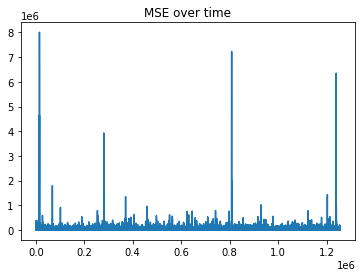

In [8]:
## TRAINING AGENT
# instantiate environment, get necessary info
train_env = StockEnv(train_data,initial_investment)
state_size = train_env.state_dim
action_size = len(train_env.action_space)

# instantiate agent
agent = DQNAgent(state_size,action_size,GAMMA,ALPHA,ETA)

# get scaler (for future normalisation)
scaler = get_scaler(train_env)

# record final value of portfolio (at end of episode)
training_portfolio_value = []

# play the game multiple times
for e in range(n_episodes):
  t0 = datetime.now() #start time
  
  # get portfolio value after playing 1 episode
  val = play_one_episode(agent, train_env, scaler, 'train')

  dt = datetime.now() - t0 #duration elapsed from start time

  if (e+1) % 100 == 0:
    print('episode %d of %d, portfolio value: %.2f, duration: %.3f' % (e+1,n_episodes,val,dt.seconds+dt.microseconds*1e-6))
  training_portfolio_value.append(val)

# plot losses
print('\n')
_ = plt.plot(agent.model.losses)
_ = plt.title('MSE over time')


# TEST

episode 100 of 2000, portfolio value: 24038.84, duration: 0.07
episode 200 of 2000, portfolio value: 23876.13, duration: 0.12
episode 300 of 2000, portfolio value: 25074.49, duration: 0.08
episode 400 of 2000, portfolio value: 22872.53, duration: 0.11
episode 500 of 2000, portfolio value: 25728.20, duration: 0.12
episode 600 of 2000, portfolio value: 25267.67, duration: 0.08
episode 700 of 2000, portfolio value: 23249.60, duration: 0.07
episode 800 of 2000, portfolio value: 22954.49, duration: 0.09
episode 900 of 2000, portfolio value: 23026.34, duration: 0.12
episode 1000 of 2000, portfolio value: 22999.59, duration: 0.06
episode 1100 of 2000, portfolio value: 23157.65, duration: 0.07
episode 1200 of 2000, portfolio value: 24867.17, duration: 0.10
episode 1300 of 2000, portfolio value: 23847.24, duration: 0.08
episode 1400 of 2000, portfolio value: 22986.96, duration: 0.12
episode 1500 of 2000, portfolio value: 23090.89, duration: 0.12
episode 1600 of 2000, portfolio value: 24668.97, 

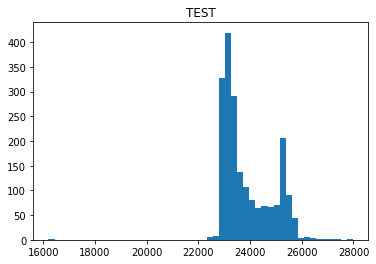

In [9]:
## TESTING AGENT
# make new environment with Test data
test_env = StockEnv(test_data,initial_investment)

# set epsilon to very small value, so that very little exploration is needed
agent.epsilon = .01

# record final value of portfolio (at end of episode)
testing_portfolio_value = []

# test the agent multiple times
for e in range(n_episodes):
  t0 = datetime.now() #start time
  
  # get portfolio value after playing 1 episode
  val = play_one_episode(agent, test_env, scaler, 'test')

  dt = datetime.now() - t0 #duration elapsed from start time
  
  if (e+1) % 100 == 0:
    print('episode %d of %d, portfolio value: %.2f, duration: %.2f' % (e+1,n_episodes,val,dt.seconds+dt.microseconds*1e-6))
  testing_portfolio_value.append(val)

# plot
_ = plt.hist(testing_portfolio_value, bins = 50)
_ = plt.title('TEST')

# print values
print('\n')
print('mean: %.2f' % np.mean(testing_portfolio_value))
print('min: %d' % np.min(testing_portfolio_value))
print('max: %d' % np.max(testing_portfolio_value))
print('\n')

It seems, on average, this RL agent gets investment returns of ~19%, running a profit majority of the time.

# Final Notes: Potential improvements.

1. Incorporate metadata, e.g. sentiment of the stock (Twitter, Google etc.)
2. Incorporate price changes
3. Use returns instead of prices

# MISC

In [11]:
# # set up environment for test mode
# #if args.mode == 'test':
# if MODE == 'test':
#   # load StandardScaler from training dataset
#   with open(f'{models_folder}/scaler.pkl','rb' as f):
#     scaler = pickle.load(f)

#   # make new environment with Test data
#   env = StockEnv(test_data,initial_investment)

#   # set epsilon to not 1, so that no exploration is needed
#   agent.epsilon = .01

#   # load trained weights
#   scaler = agent.load(f'{models_folder}/linear.npz')

In [12]:
# # add argument parser so we can run script in CLI (outside of .ipynb environment)
# parser = argparse.ArgumentParser()
# parser.add_argument('-m','--mode',type = str, required = True, help = 'either "train" or "test"')
# args = parser.parse_args()

In [13]:
# model_folder = './'
# rewards_folder = './'

# # make directories if non-existent
# make_dir(model_folder)
# make_dir(rewards_folder)

# credits

https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python